In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cuda') # 设备

class ActionDataset(Dataset):
    """Action dataset."""

    def __init__(self,  root_dir, labels=[], transform=None):
        """
        Args:
            root_dir (string): 整个数据的路径。
            labels(list): 图片的标签。
            transform (callable, optional): 想要对数据进行的处理函数。
        """
        self.root_dir = root_dir
        self.transform = transform
        self.length=len(os.listdir(self.root_dir))
        self.labels=labels

    def __len__(self):      # 该方法只需返回数据的数量。
        return self.length*3    # 因为每个视频片段都包含3帧。

    def __getitem__(self, idx):     # 该方法需要返回一个数据。
        folder=idx//3+1
        imidx=idx%3+1
        folder=format(folder,'05d')
        imgname=str(imidx)+'.jpg'
        img_path = os.path.join(self.root_dir,folder,imgname)
        image = Image.open(img_path)

        if len(self.labels)!=0:
            Label=self.labels[idx//3][0]-1
        if self.transform:      # 如果要先对数据进行预处理，则经过transform函数。
            image = self.transform(image)
        if len(self.labels)!=0:
            sample={'image':image,'img_path':img_path,'Label':Label}
        else:
            sample={'image':image,'img_path':img_path}
        return sample

class LeNet5(nn.Module):
    def __init__(self,num_class=10):
        super(LeNet5,self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool1 = nn.AvgPool2d((2, 2))
        
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.pool2 = nn.AvgPool2d((2, 2))
        
        self.conv3 = nn.Conv2d(16, 32, 5)
        
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(2592, 1024)
        self.fc2 = nn.Linear(1024, num_class)
        
    def forward(self, x):
        # x: torch.Size([32, 3, 64, 64])
        
        x = self.conv1(x) # torch.Size([32, 8, 60, 60])
        x = self.relu(x)
        x = self.pool1(x) # torch.Size([32, 8, 30, 30])

        x = self.conv2(x) # torch.Size([32, 16, 26, 26])
        x = self.relu(x)
        x = self.pool2(x) # torch.Size([32, 16, 13, 13])

        x = self.conv3(x) # torch.Size([32, 32, 9, 9])
        x = self.relu(x)
        
        x = x.flatten(start_dim=1) # torch.Size([32, 2592])
        
        x = self.fc1(x) # torch.Size([32, 1024])
        x = self.relu(x)
        x = self.fc2(x) # torch.Size([32, 10])

        return x
    
train_dataset = ActionDataset(root_dir=root_path+'/trainClips/', labels=label_train, transform=T.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
cloth_list = train_dataset.labels
print(cloth_list)
class_dict = {}
for keyName,index in cloth_list:
    class_dict[index] = keyName

[[ 1.]
 [ 1.]
 [ 1.]
 ...
 [10.]
 [10.]
 [10.]]


AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [51]:
# 视频分类模型
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,sampler,Dataset
import torchvision.datasets as dset
import torchvision.transforms as T
import timeit
from PIL import Image
import os
import numpy as np
import scipy.io
import torchvision.models.inception as inception
from tqdm import tqdm

# 模型输入参数，需要自己根据需要调整
num_class = 10 # 分类数
epochs = 5 # 迭代次数
batch_size = 32 # 每个批次样本大小
lr = 0.003 # 学习率
root_path = '../../../data/case_1'
save_path = root_path+'/best_model.pkl' # 模型保存路径


label_mat=scipy.io.loadmat(root_path+'/q3_2_data.mat')
label_train=label_mat['trLb']
print('train len：',len(label_train))





# 6.模型训练
model = LeNet5(num_class)
model = model.to(device)
criterion = nn.CrossEntropyLoss() # 损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 优化器

best_acc = 0 # 最优精确率
best_model = None # 最优模型参数

for epoch in range(epochs):
    model.train()
    running_loss = 0 # 损失
    epoch_acc = 0  # 每个epoch的准确率
    epoch_acc_count = 0  # 每个epoch训练的样本数
    train_count = 0  # 用于计算总的样本数，方便求准确率
    train_bar = tqdm(train_loader)
    for data in train_bar:
        images, labels = data['image'], data['Label']
        optimizer.zero_grad()
        output = model(images.to(device))
        loss = criterion(output, labels.long().to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)
        # 计算每个epoch正确的个数
        print(111,output.argmax(axis=1),labels.to(device).view(-1))
        epoch_acc_count += (output.argmax(axis=1) == labels.to(device).view(-1)).sum()
        train_count += len(images)

    # 每个epoch对应的准确率
    epoch_acc = epoch_acc_count / train_count

    # 打印信息
    print("【EPOCH: 】%s" % str(epoch + 1))
    print("训练损失为%s" % str(running_loss))
    print("训练精度为%s" % (str(epoch_acc.item() * 100)[:5]) + '%')

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = model.state_dict()

    # 在训练结束保存最优的模型参数
    if epoch == epochs - 1:
        # 保存模型
        torch.save(best_model, save_path)

print('Finished Training')



train len： 7770


train epoch[1/5] loss:2.304:   0%|          | 1/729 [00:00<04:54,  2.48it/s]

111 tensor([6, 4, 6, 6, 6, 4, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6,
        6, 6, 6, 6, 4, 6, 6, 6], device='cuda:0') tensor([7., 6., 1., 1., 3., 4., 5., 8., 1., 7., 1., 0., 5., 8., 5., 3., 9., 6.,
        3., 7., 9., 8., 0., 7., 7., 6., 4., 9., 2., 2., 5., 2.],
       device='cuda:0', dtype=torch.float64)


train epoch[1/5] loss:2.296:   0%|          | 2/729 [00:00<05:11,  2.34it/s]

111 tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0') tensor([1., 1., 5., 6., 5., 8., 9., 6., 9., 8., 9., 0., 8., 1., 7., 2., 0., 5.,
        2., 2., 1., 8., 7., 0., 3., 6., 5., 4., 2., 5., 3., 6.],
       device='cuda:0', dtype=torch.float64)


train epoch[1/5] loss:2.272:   0%|          | 3/729 [00:01<05:05,  2.37it/s]

111 tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0') tensor([8., 9., 2., 5., 5., 0., 5., 5., 1., 3., 7., 9., 3., 2., 3., 8., 1., 5.,
        3., 8., 0., 8., 9., 1., 0., 3., 4., 3., 5., 8., 8., 8.],
       device='cuda:0', dtype=torch.float64)


train epoch[1/5] loss:2.382:   1%|          | 4/729 [00:01<04:47,  2.52it/s]

111 tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0') tensor([1., 4., 3., 3., 0., 7., 5., 7., 7., 1., 8., 9., 4., 2., 3., 2., 3., 1.,
        4., 8., 8., 5., 4., 1., 3., 0., 9., 2., 5., 9., 3., 1.],
       device='cuda:0', dtype=torch.float64)


train epoch[1/5] loss:2.304:   1%|          | 5/729 [00:01<04:36,  2.62it/s]

111 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0') tensor([9., 1., 6., 5., 5., 1., 5., 9., 7., 1., 7., 3., 0., 0., 1., 4., 0., 7.,
        3., 3., 5., 2., 0., 5., 1., 3., 4., 1., 6., 0., 2., 3.],
       device='cuda:0', dtype=torch.float64)


train epoch[1/5] loss:2.318:   1%|          | 6/729 [00:02<04:19,  2.79it/s]

111 tensor([3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3], device='cuda:0') tensor([8., 6., 1., 5., 7., 0., 0., 9., 5., 7., 1., 3., 1., 9., 7., 7., 8., 1.,
        3., 6., 7., 1., 6., 3., 6., 8., 8., 4., 6., 2., 6., 3.],
       device='cuda:0', dtype=torch.float64)


train epoch[1/5] loss:2.319:   1%|          | 7/729 [00:02<04:18,  2.80it/s]

111 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([4., 3., 9., 0., 0., 7., 6., 0., 6., 1., 2., 5., 6., 4., 9., 0., 8., 7.,
        3., 9., 7., 9., 2., 2., 1., 3., 9., 7., 5., 2., 8., 7.],
       device='cuda:0', dtype=torch.float64)


train epoch[1/5] loss:2.276:   1%|          | 8/729 [00:03<04:21,  2.75it/s]

111 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([0., 0., 5., 9., 7., 7., 5., 2., 1., 0., 0., 5., 3., 4., 4., 3., 7., 1.,
        3., 9., 3., 7., 4., 0., 7., 1., 1., 9., 9., 3., 4., 7.],
       device='cuda:0', dtype=torch.float64)


train epoch[1/5] loss:2.303:   1%|          | 9/729 [00:03<05:10,  2.32it/s]

111 tensor([5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([4., 8., 6., 6., 2., 6., 9., 8., 8., 1., 4., 0., 2., 9., 0., 6., 3., 1.,
        1., 8., 2., 0., 0., 0., 5., 0., 3., 6., 5., 3., 4., 2.],
       device='cuda:0', dtype=torch.float64)


train epoch[1/5] loss:2.283:   1%|▏         | 10/729 [00:04<04:52,  2.46it/s]

111 tensor([3, 3, 3, 3, 3, 3, 3, 7, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 7, 3, 3], device='cuda:0') tensor([5., 4., 9., 8., 1., 6., 4., 6., 9., 7., 4., 5., 3., 2., 3., 0., 0., 1.,
        8., 8., 5., 3., 2., 0., 0., 0., 8., 6., 9., 0., 0., 0.],
       device='cuda:0', dtype=torch.float64)


KeyboardInterrupt: 

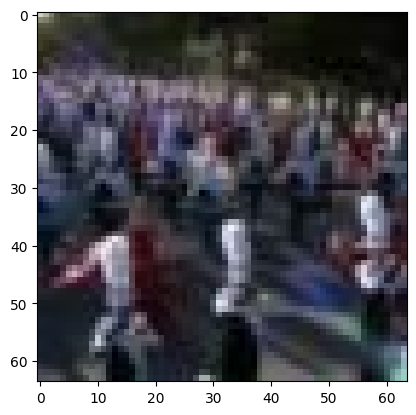

8


In [49]:
import pickle
from torchvision import transforms,datasets
import matplotlib.pyplot as plt
import tensorflow as tf
root_path = '../../../data/case_1'
model_path = root_path+'/best_model.pkl'
model = LeNet5().to(device)
model.load_state_dict(torch.load(model_path))

data_transform2 = transforms.Compose(
    [
        # transforms.Resize(32),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=mean,std=std)
    ]
)
# 将模型设置为评估模式
model.eval()
with torch.no_grad():
    # 图片路径
    test_image_path = root_path + '/valClips/00100/1.jpg'
    # 打开图片
    img = Image.open(test_image_path)
    # 对图像转换
    img = data_transform2(img)
    plt.imshow(img.permute(1,2,0))
    plt.show()
    img = torch.unsqueeze(img,dim=0)
    img = img.to(device)
   
    print(model(img).argmax(axis=1).item())
        

    # pred = train_dataset [model(img).argmax(axis=1).item()]
    # print('[预测结果分类]: %s' %pred)

